In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix, classification_report

import keras
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

##Preparing Data

In [3]:
dataset = pd.read_csv('/content/gdrive/MyDrive/A/dataset/ham10000/HAM10000_metadata.csv')

In [4]:
name_dict = {
    'nv': 'melanocytic nevi',
    'mel': 'melanoma',
    'bcc': 'basal cell carcinoma',
    'akiec': 'Actinic keratoses and intraepithelial carcinoma',
    'vasc': 'vascular lesions',
    'bkl': 'benign keratosis-like',
    'df': 'dermatofibroma'
}
dataset['name'] = dataset['dx'].map(name_dict.get)
name_id_dict = {name: id for id, name in enumerate(name_dict.keys())}
dataset['label'] = dataset['dx'].map(name_id_dict.get).astype(int)
dataset.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,name,label
1617,HAM_0007180,ISIC_0033272,mel,histo,65.0,male,face,melanoma,1
8128,HAM_0007195,ISIC_0031923,nv,histo,40.0,female,lower extremity,melanocytic nevi,0
2168,HAM_0001835,ISIC_0026652,mel,histo,65.0,male,back,melanoma,1
1090,HAM_0000465,ISIC_0030583,bkl,consensus,35.0,female,trunk,benign keratosis-like,5
7754,HAM_0001720,ISIC_0034010,nv,histo,45.0,male,abdomen,melanocytic nevi,0


In [5]:
print(dataset['label'].value_counts())

0    6705
1    1113
5    1099
2     514
3     327
4     142
6     115
Name: label, dtype: int64


In [6]:
from sklearn.utils import resample

data_0 = dataset[dataset['label'] == 0]
data_1 = dataset[dataset['label'] == 1]
data_2 = dataset[dataset['label'] == 2]
data_3 = dataset[dataset['label'] == 3]
data_4 = dataset[dataset['label'] == 4]
data_5 = dataset[dataset['label'] == 5]
data_6 = dataset[dataset['label'] == 6]

n_samples=500 
data_0_balanced = resample(data_0, replace=True, n_samples=n_samples, random_state=42) 
data_1_balanced = resample(data_1, replace=True, n_samples=n_samples, random_state=42) 
data_2_balanced = resample(data_2, replace=True, n_samples=n_samples, random_state=42)
data_3_balanced = resample(data_3, replace=True, n_samples=n_samples, random_state=42)
data_4_balanced = resample(data_4, replace=True, n_samples=n_samples, random_state=42)
data_5_balanced = resample(data_5, replace=True, n_samples=n_samples, random_state=42)
data_6_balanced = resample(data_6, replace=True, n_samples=n_samples, random_state=42)

dataset_balanced = pd.concat([data_0_balanced, data_1_balanced, 
                              data_2_balanced, data_3_balanced, 
                              data_4_balanced, data_5_balanced, 
                              data_6_balanced])

print(dataset_balanced['label'].value_counts())

5    500
3    500
1    500
6    500
4    500
2    500
0    500
Name: label, dtype: int64


In [7]:
size=160
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('/content/gdrive/MyDrive/A/dataset/ham10000/', '*', '*.jpg'))}


dataset_balanced['path'] = dataset['image_id'].map(image_path.get)

dataset_balanced['image'] = dataset_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((size, size))))

In [8]:
X = np.asarray(dataset_balanced['image'].tolist())
X = X/255.  
Y=dataset_balanced['label'] 
Y_cat = to_categorical(Y, num_classes=7) 
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

##Model

In [14]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
size = 160
training = MobileNetV2(include_top = False,
                       input_shape = (size, size, 3))

model = Sequential()
model.add(training)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

for layer in model.layers[0].layers:
    layer.trainable = False

model.summary()

model.compile(Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=["acc"])

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16384512  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
___________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=25,
                    verbose=1)

Epoch 1/25
83/83 [==============================] - 55s 624ms/step - loss: 2.0738 - acc: 0.2408 - val_loss: 1.5583 - val_acc: 0.4400
Epoch 2/25
83/83 [==============================] - 52s 634ms/step - loss: 1.6902 - acc: 0.3356 - val_loss: 1.4361 - val_acc: 0.4949
Epoch 3/25
83/83 [==============================] - 53s 635ms/step - loss: 1.5948 - acc: 0.3901 - val_loss: 1.3311 - val_acc: 0.5497
Epoch 4/25
83/83 [==============================] - 53s 640ms/step - loss: 1.4502 - acc: 0.4446 - val_loss: 1.2138 - val_acc: 0.6023
Epoch 5/25
83/83 [==============================] - 53s 637ms/step - loss: 1.3620 - acc: 0.4781 - val_loss: 1.1821 - val_acc: 0.5897
Epoch 6/25
83/83 [==============================] - 53s 637ms/step - loss: 1.2456 - acc: 0.5310 - val_loss: 1.0725 - val_acc: 0.6411
Epoch 7/25
83/83 [==============================] - 53s 641ms/step - loss: 1.1694 - acc: 0.5570 - val_loss: 0.9977 - val_acc: 0.6766
Epoch 8/25
83/83 [==============================] - 53s 644ms/step - 

In [16]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 13s 460ms/step - loss: 0.7079 - acc: 0.8160
Test accuracy: 0.8159999847412109


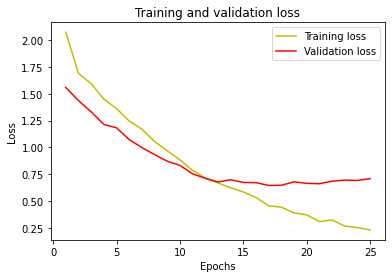

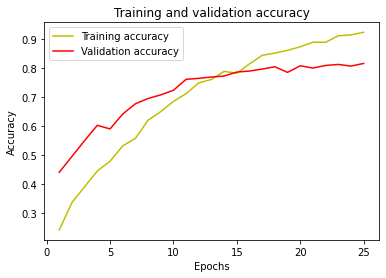

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


              precision    recall  f1-score   support

           0       0.85      0.71      0.78       149
           1       0.62      0.78      0.69       128
           2       0.86      0.81      0.83       120
           3       0.77      0.87      0.82       128
           4       0.93      0.99      0.96       112
           5       0.73      0.58      0.64       113
           6       0.98      0.99      0.99       125

    accuracy                           0.82       875
   macro avg       0.82      0.82      0.82       875
weighted avg       0.82      0.82      0.81       875



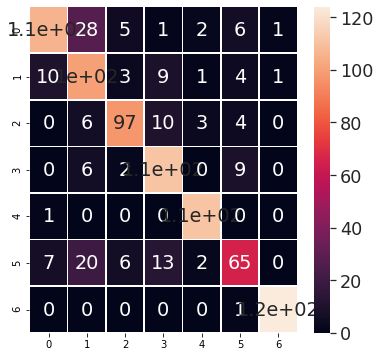

In [18]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

pd.DataFrame(confusion_matrix(y_true, y_pred_classes), columns = ["prediction1","prediction2","prediction3","prediction4","prediction5","prediction6","prediction7"], index = ["True1","True2","True3","True4","True5","True6","True7"])

print(classification_report(y_true, y_pred_classes))

In [19]:
%cd /content/gdrive/MyDrive/A

/content/gdrive/MyDrive/A


In [20]:
model.save("model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [21]:
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [23]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████████████| 112kB 10.5MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


In [24]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [25]:
import tensorflow as tf
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpzqagna8k/assets


INFO:tensorflow:Assets written to: /tmp/tmpzqagna8k/assets


In [26]:
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.externals import joblib  

boston_set = datasets.load_boston()

model = RandomForestRegressor()
model.fit(boston_set.data, boston_set.target)

joblib.dump(model, 'model.joblib')

with open('model.pkl','wb') as model_file:
  pickle.dump(model, model_file)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
